In [46]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

#Alpha vantage

2OQT6WT9WH45WTK5

In [35]:
myticker = "AAPL"
df = pd.read_csv(f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={myticker}&apikey=2OQT6WT9WH45WTK5&datatype=csv')
df

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
0,2023-03-24,158.860,160.3400,157.85,160.25,160.250000,59256343,0.00,1.0
1,2023-03-23,158.830,161.5501,157.68,158.93,158.930000,67622060,0.00,1.0
2,2023-03-22,159.300,162.1400,157.81,157.83,157.830000,75701811,0.00,1.0
3,2023-03-21,157.320,159.4000,156.54,159.28,159.280000,73938285,0.00,1.0
4,2023-03-20,155.070,157.8200,154.15,157.40,157.400000,73641415,0.00,1.0
...,...,...,...,...,...,...,...,...,...
95,2022-11-04,142.090,142.6700,134.38,138.38,137.995101,140814796,0.23,1.0
96,2022-11-03,142.060,142.8000,138.75,138.88,138.263903,97918516,0.00,1.0
97,2022-11-02,148.945,152.1700,145.00,145.03,144.386621,93604623,0.00,1.0
98,2022-11-01,155.080,155.4500,149.13,150.65,149.981689,80379345,0.00,1.0


In [54]:
df1 = df.reset_index()["close"]
df1

0     160.25
1     158.93
2     157.83
3     159.28
4     157.40
       ...  
95    138.38
96    138.88
97    145.03
98    150.65
99    153.34
Name: close, Length: 100, dtype: float64

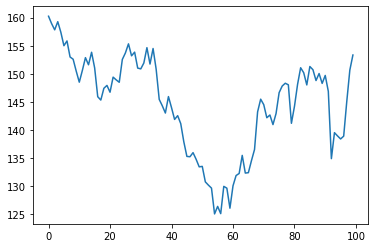

In [57]:
df1.plot()
plt.show()

In [58]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))
df1

array([[1.        ],
       [0.96253193],
       [0.93130854],
       [0.97246665],
       [0.91910304],
       [0.85097928],
       [0.87510644],
       [0.79392563],
       [0.78257167],
       [0.72239569],
       [0.66647743],
       [0.72580187],
       [0.79051944],
       [0.75447062],
       [0.81776895],
       [0.73829123],
       [0.59296054],
       [0.57592961],
       [0.63553789],
       [0.65001419],
       [0.61566846],
       [0.69202384],
       [0.67811524],
       [0.66590974],
       [0.78143628],
       [0.81436276],
       [0.8603463 ],
       [0.79988646],
       [0.81833664],
       [0.73772353],
       [0.73374965],
       [0.76355379],
       [0.84104456],
       [0.75816066],
       [0.83678683],
       [0.7323304 ],
       [0.57933579],
       [0.54697701],
       [0.51036049],
       [0.59352824],
       [0.53760999],
       [0.4780017 ],
       [0.49701959],
       [0.45671303],
       [0.36474596],
       [0.29094522],
       [0.28924212],
       [0.309

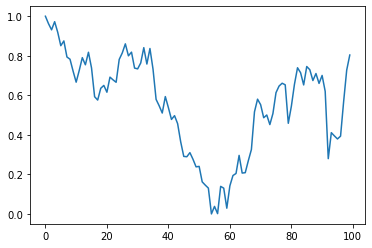

In [59]:
plt.plot(df1)
plt.show()

In [60]:
scaler.inverse_transform(df1[1].reshape(-1, 1))

array([[158.93]])

# Dataset

In [112]:
df_len = int(len(df1))
training_size = int(df_len * 0.65)
testing_size = df_len - training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [137]:
class StockDataset(Dataset):
    def __init__(self,data,seq_len = 20):
        self.data = data
        self.data = torch.from_numpy(data).float().view(-1)
        self.seq_len = seq_len
        
    def __len__(self):
        return len(self.data)-self.seq_len-1

    def __getitem__(self, index) :
        # return x, y
        return  self.data[index : index+self.seq_len] , self.data[index+self.seq_len]


train_dataset = StockDataset(train_data) 
test_dataset = StockDataset(test_data)

In [151]:
batch_size = 4
train_dataloader = DataLoader(train_dataset,batch_size,drop_last=True)
test_dataloader = DataLoader(test_dataset,batch_size , drop_last=True)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [152]:
class Lstm_model(nn.Module):
    def __init__(self, input_dim , hidden_size , num_layers):
        super(Lstm_model, self).__init__()
        self.num_layers = num_layers
        self.input_size = input_dim
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_dim , hidden_size = hidden_size , num_layers= num_layers )
        self.fc = nn.Linear(hidden_size,1)

    def forward(self,x,hn,cn):
        out , (hn,cn) = self.lstm(x , (hn,cn))
        final_out = self.fc(out[-1])
        return final_out,hn,cn

    def predict(self,x):
        hn,cn  = self.init()
        final_out = self.fc(out[-1])
        return final_out

    def init(self):
        h0 =  torch.zeros(self.num_layers , batch_size , self.hidden_size).to(device)
        c0 =  torch.zeros(self.num_layers , batch_size , self.hidden_size).to(device)
        return h0 , c0


input_dim = 1 
hidden_size = 50
num_layers = 3
model = Lstm_model(input_dim , hidden_size , num_layers).to(device)


In [153]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [154]:
def train(dataloader):
    hn , cn = model.init()
    model.train()
    for batch , item in enumerate(dataloader):
        x , y = item
        x = x.to(device)
        y = y.to(device)
        out , hn , cn = model(x.reshape(20,batch_size,1),hn,cn)
        loss = loss_fn(out.reshape(batch_size) , y)
        hn = hn.detach()
        cn = cn.detach()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch == len(dataloader)-1:
            loss = loss.item()
            print(f"train loss: {loss:>7f} ")

In [157]:
def test(dataloader):
    hn , cn = model.init()
    model.eval()
    for batch , item in enumerate(dataloader):
        x , y = item
        x = x.to(device)
        y = y.to(device)
        out , hn , cn = model(x.reshape(20,batch_size,1),hn,cn)
        loss = loss_fn(out.reshape(batch_size) , y)
       
        if batch == len(dataloader)-1:
            loss = loss.item()
            print(f"test loss: {loss:>7f} ")

In [158]:
epochs = 200
for epoch in range(epochs):
    print(f"epoch {epoch} ")
    train(train_dataloader)
    test(test_dataloader)


epoch 0 
train loss: 0.080075 
test loss: 0.007702 
epoch 1 
train loss: 0.042459 
test loss: 0.000591 
epoch 2 
train loss: 0.044490 
test loss: 0.001304 
epoch 3 
train loss: 0.051985 
test loss: 0.003229 
epoch 4 
train loss: 0.049160 
test loss: 0.003005 
epoch 5 
train loss: 0.043820 
test loss: 0.002500 
epoch 6 
train loss: 0.040997 
test loss: 0.002829 
epoch 7 
train loss: 0.036983 
test loss: 0.003018 
epoch 8 
train loss: 0.030732 
test loss: 0.002767 
epoch 9 
train loss: 0.023764 
test loss: 0.002373 
epoch 10 
train loss: 0.016663 
test loss: 0.001633 
epoch 11 
train loss: 0.011146 
test loss: 0.001161 
epoch 12 
train loss: 0.007118 
test loss: 0.000645 
epoch 13 
train loss: 0.004981 
test loss: 0.001101 
epoch 14 
train loss: 0.003637 
test loss: 0.000161 
epoch 15 
train loss: 0.003920 
test loss: 0.004433 
epoch 16 
train loss: 0.009696 
test loss: 0.003800 
epoch 17 
train loss: 0.004646 
test loss: 0.005520 
epoch 18 
train loss: 0.007181 
test loss: 0.001144 
epo

test loss: 0.000788 
epoch 155 
train loss: 0.000782 
test loss: 0.001200 
epoch 156 
train loss: 0.000704 
test loss: 0.001065 
epoch 157 
train loss: 0.001037 
test loss: 0.000959 
epoch 158 
train loss: 0.000637 
test loss: 0.001788 
epoch 159 
train loss: 0.000817 
test loss: 0.001739 
epoch 160 
train loss: 0.000767 
test loss: 0.002828 
epoch 161 
train loss: 0.001326 
test loss: 0.002373 
epoch 162 
train loss: 0.001509 
test loss: 0.003499 
epoch 163 
train loss: 0.002990 
test loss: 0.001765 
epoch 164 
train loss: 0.001234 
test loss: 0.005258 
epoch 165 
train loss: 0.001313 
test loss: 0.000524 
epoch 166 
train loss: 0.001172 
test loss: 0.007653 
epoch 167 
train loss: 0.002634 
test loss: 0.001100 
epoch 168 
train loss: 0.000592 
test loss: 0.002914 
epoch 169 
train loss: 0.000674 
test loss: 0.001440 
epoch 170 
train loss: 0.001052 
test loss: 0.002110 
epoch 171 
train loss: 0.001019 
test loss: 0.003132 
epoch 172 
train loss: 0.002061 
test loss: 0.002027 
epoch 1

In [167]:
import math
from sklearn.metrics import mean_squared_error
import numpy as np
def calculate_metrics(data_loader):
    pred_arr = []
    y_arr = []
    with torch.no_grad():
        hn , cn = model.init()
        for batch , item in enumerate(data_loader):
            x , y = item
            x , y = x.to(device) , y.to(device)
            x = x.view(20,4,1)
            pred = model(x,hn,cn)[0]
            pred = scaler.inverse_transform(pred.detach().cpu().numpy()).reshape(-1)
            y = scaler.inverse_transform(y.detach().cpu().numpy().reshape(1,-1)).reshape(-1)
            pred_arr = pred_arr + list(pred)
            y_arr = y_arr + list(y)
        print(pred_arr[11],y_arr[11])
        return math.sqrt(mean_squared_error(y_arr,pred_arr))
    

In [168]:
# calculating final loss metrics
print(f"train mse loss {calculate_metrics(train_dataloader)}")
print(f"test mse loss {calculate_metrics(test_dataloader)}")

149.66963 151.92
train mse loss 3.228683550391226
143.57759 138.88
test mse loss 7.098104476422077
